In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set()

col_pal = sns.color_palette()
warnings.filterwarnings('ignore')

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
dataframe = pd.read_csv("https://raw.githubusercontent.com/saifghostrider454/AdvertisementCaseStudy/main/EDA/Dataset.csv")

In [9]:
sales_data = dataframe[['Order Date','Sales']].copy()

In [10]:
sales_data['Sales'] = sales_data['Sales'].str.split(",").str.join("").astype('int')

In [11]:
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'], format="%d-%m-%Y")

In [98]:
sales_data['Month_Year'] = sales_data['Order Date'].dt.to_period('M')

In [37]:
sales_data.drop(columns='Order Date', inplace=True)

In [12]:
sales_data.sample(5)

,Order Date,Sales
46195,2014-10-17,16
10499,2012-03-26,3394
40125,2014-06-23,22
50180,2014-12-15,17
21170,2013-02-25,98


In [79]:
sales_data.shape

(51290, 2)

In [13]:
sales_data = sales_data.groupby('Order Date')['Sales'].sum().reset_index()

In [14]:
sales_data.set_index('Order Date', inplace=True)

sales_data.shape

(1430, 1)

In [15]:
sales_data

,Sales
Order Date,
2011-01-01,808
2011-01-02,314
2011-01-03,4502
2011-01-04,2809
2011-01-05,3664
...,...
2014-12-27,13418
2014-12-28,1646
2014-12-29,25106


<Axes: title={'center': 'Sales'}, xlabel='Order Date'>

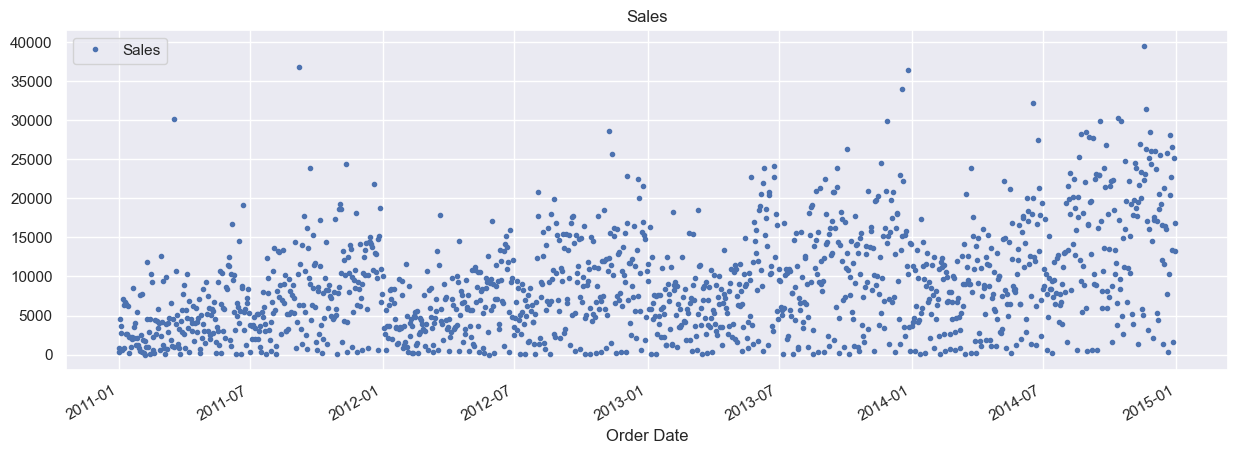

In [84]:
sales_data.plot(style='.', 
                figsize=[15, 5], 
                color=col_pal, 
                title='Sales')

In [86]:
min(sales_data.index), max(sales_data.index)

(Timestamp('2011-01-01 00:00:00'), Timestamp('2014-12-31 00:00:00'))

In [16]:
train = sales_data.loc[sales_data.index < '2014-01-01']
test = sales_data.loc[sales_data.index > '2014-01-01']

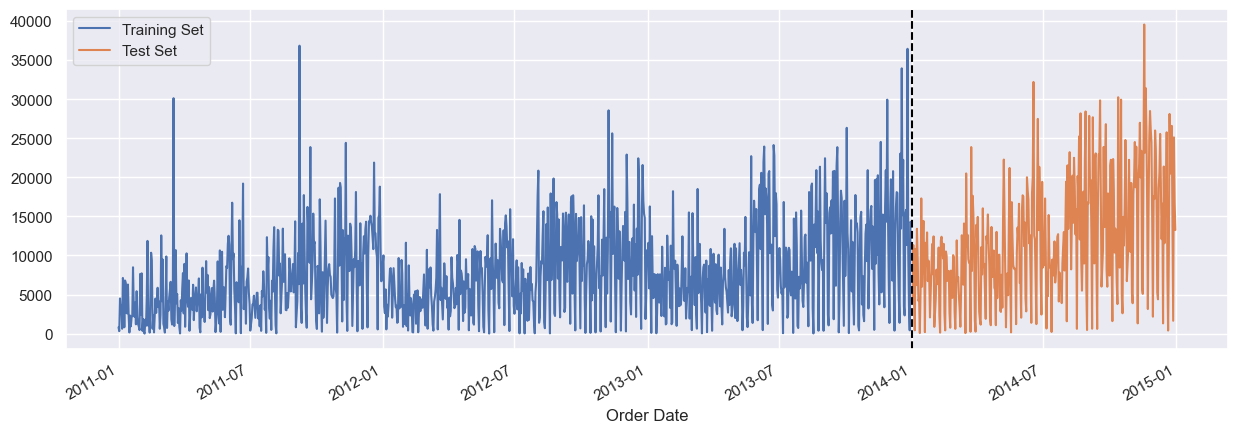

In [91]:
fig, ax = plt.subplots(figsize=[15, 5])

train.plot(ax=ax, label='Training Set')

test.plot(ax=ax, label='Test Set')

ax.axvline('2014-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.show()

In [30]:
def create_features(sales_data):

    sales_data = sales_data.copy()

    sales_data['Dayofyear'] = sales_data.index.dayofyear
    sales_data['Dayofweek'] = sales_data.index.day_of_week
    sales_data['Month'] = sales_data.index.month
    sales_data['Year'] = sales_data.index.year
    sales_data['quarter'] = sales_data.index.quarter

    return sales_data

In [31]:
sales_data = create_features(sales_data)

In [32]:
train = create_features(train)
test = create_features(test)

<Axes: xlabel='Dayofweek', ylabel='Sales'>

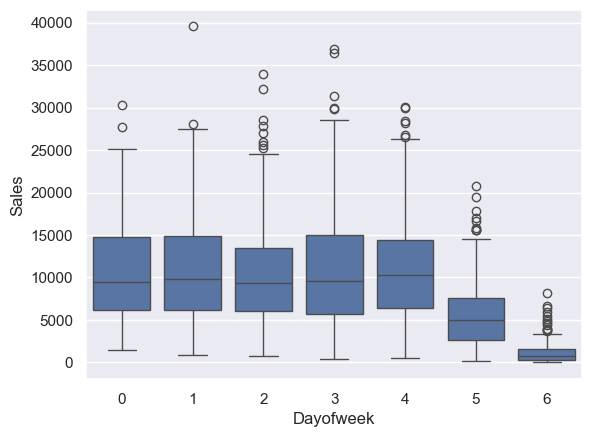

In [113]:
sns.boxplot(data=sales_data, x='Dayofweek', y='Sales')

In [33]:
FEATURES = ['Dayofyear', 'Dayofweek', 'Month', 'Year', 'quarter']
TARGET = ['Sales']

In [34]:
X_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [36]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_round=50, learning_rate=0.01)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (x_test, y_test)], verbose=100)

[0]	validation_0-rmse:5764.66229	validation_1-rmse:8661.37965
[100]	validation_0-rmse:3876.14328	validation_1-rmse:6471.23403
[200]	validation_0-rmse:3312.46750	validation_1-rmse:5920.17404
[300]	validation_0-rmse:3078.79585	validation_1-rmse:5754.74103
[400]	validation_0-rmse:2905.10480	validation_1-rmse:5716.00529
[500]	validation_0-rmse:2766.48259	validation_1-rmse:5725.34546
[600]	validation_0-rmse:2679.12308	validation_1-rmse:5745.22926
[700]	validation_0-rmse:2608.58253	validation_1-rmse:5763.84607
[800]	validation_0-rmse:2522.95096	validation_1-rmse:5791.39921
[900]	validation_0-rmse:2449.61228	validation_1-rmse:5816.01732
[999]	validation_0-rmse:2384.74186	validation_1-rmse:5829.65770


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [39]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importance'])

<Axes: title={'center': 'Feature Importance'}>

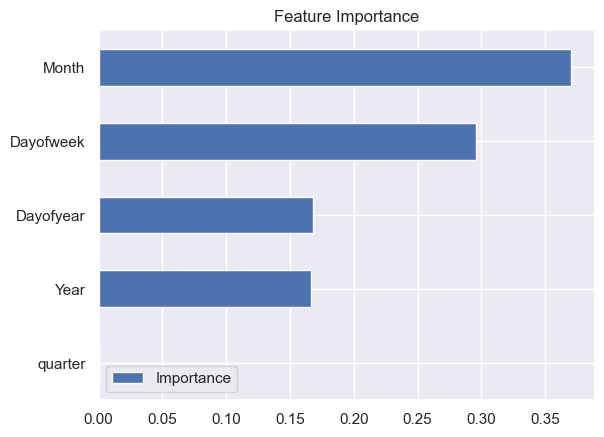

In [40]:
fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')

In [42]:
test['prediction'] = reg.predict(x_test)

In [45]:
sales_data = sales_data.merge(test['prediction'], how='left', left_index=True, right_index=True)

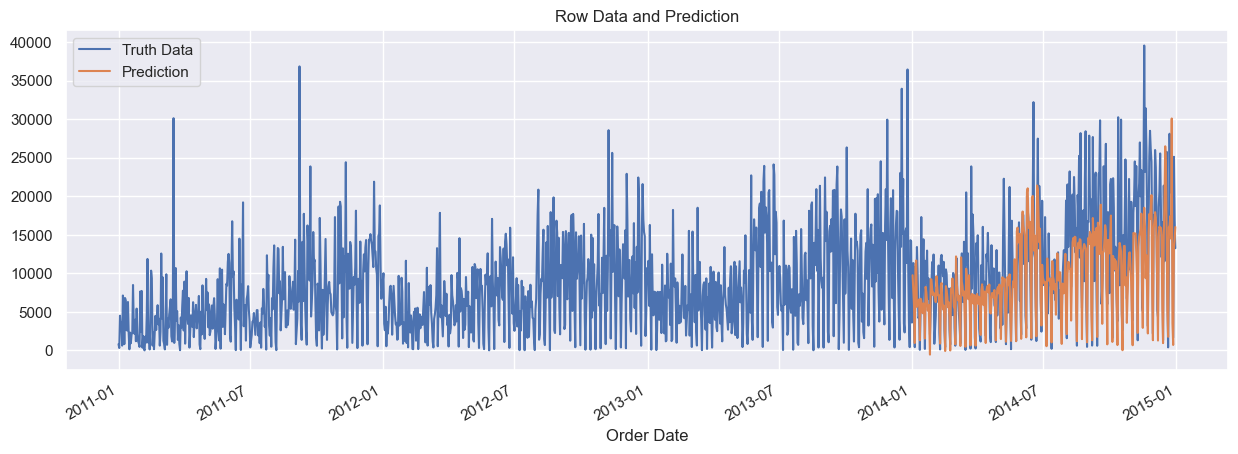

In [47]:
ax = sales_data[['Sales']].plot(figsize=[15, 5])
sales_data['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Row Data and Prediction')
plt.show()

In [49]:
r2_score(y_test, reg.predict(x_test))

0.42067531812635583